In [4]:
from glob import glob
from src.systems.mountain_car import MountainCarSystem
from src.flow_matching.mountain_car.latent_conditional.flow_matcher import MountainCarLatentConditionalFlowMatcher
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import os
import torch

data_dir = "/common/users/shared/pracsys/genMoPlan/data_trajectories/mountain_car_power_0p0008"
roa_file = "/common/users/shared/pracsys/genMoPlan/data_trajectories/mountain_car_power_0p0008/roa_labels.txt"
bounds_file = "/common/users/dm1487/arcmg_datasets/mountain_car_power_0p0008/mountain_car_data_bounds.pkl"


system = MountainCarSystem(bounds_file=bounds_file, use_dynamic_bounds=True)
 

ckpt_path = "/common/home/dm1487/robotics_research/tripods/olympics-classifier/outputs/mountain_car_power_p0008/2025-11-05_20-52-17"
flow_matcher = MountainCarLatentConditionalFlowMatcher.load_from_checkpoint(ckpt_path, device="cuda:0")

✅ Loaded MountainCar bounds from: /common/users/dm1487/arcmg_datasets/mountain_car_power_0p0008/mountain_car_data_bounds.pkl
   Position limit: ±2.0000
   Velocity limit: ±0.1000
📁 Folder provided: /common/home/dm1487/robotics_research/tripods/olympics-classifier/outputs/mountain_car_power_p0008/2025-11-05_20-52-17
🔍 Searching for checkpoint in folder...
   ✓ Found best checkpoint (val_loss=0.0014)
   📄 Using: epoch36-val_loss0.0014.ckpt
🤖 Loading Mountain Car flow matcher checkpoint: /common/home/dm1487/robotics_research/tripods/olympics-classifier/outputs/mountain_car_power_p0008/2025-11-05_20-52-17/version_0/checkpoints/epoch36-val_loss0.0014.ckpt
📍 Device: cuda:0
🗂️  Training directory: /common/home/dm1487/robotics_research/tripods/olympics-classifier/outputs/mountain_car_power_p0008/2025-11-05_20-52-17
📋 Loading Hydra config: /common/home/dm1487/robotics_research/tripods/olympics-classifier/outputs/mountain_car_power_p0008/2025-11-05_20-52-17/.hydra/config.yaml
✅ Hydra config load

In [5]:

# labels = {}
# success_ctr = 0
# main_dir = "/common/users/shared/pracsys/genMoPlan/data_trajectories/humanoid_get_up_slow"
# with open(main_dir + "/shuffled_indices.txt", "r") as f:
#     for line in tqdm(f.readlines()):
#         data = np.loadtxt(main_dir + "/trajectories/" + line.strip(), delimiter=",")
#         ctr = 0
#         for i in range(data.shape[0]-5, data.shape[0]):
#             if system.is_in_attractor(data[i:i+1]).item():
#                 ctr  += 1
#         if ctr == 5:
#             labels[line.strip()] = 1
#             success_ctr += 1
#         else:
#             labels[line.strip()] = 0

In [6]:
# success_ctr/15000

In [7]:
# start_states = []
# final_states = []

# split_labels = []
# with open(data_dir + "/shuffled_indices.txt", "r") as f:
#     for line in tqdm(f.readlines()):
#         data = np.loadtxt(data_dir + "/split_trajectories/" + line.strip(), delimiter=",")
#         if len(data.shape) > 1:
#             start_states.append(data[0, :])
#             final_states.append(data[-1, :])
#             # print(line.strip().split("_part")[0]+ ".txt", labels[line.strip().split("_part")[0] + ".txt"])
#             split_labels.append(labels[line.strip().split("_part")[0] + ".txt"])
            
# split_labels = np.array(split_labels)


In [8]:
# np.mean(split_labels), np.mean(np.array([i for i in labels.values()]))

In [11]:
roa_data = np.loadtxt(roa_file, delimiter=",")
inp, labels = roa_data[:, :2], roa_data[:, -1]
inp = torch.from_numpy(inp).float().to("cuda:0")
labels = torch.from_numpy(labels).long().to("cuda:0")
np.mean(roa_data[:, -1] == 1)


0.48254166666666665

In [12]:
# from tqdm import tqdm
# samples = 20
# repeats = 1

# tp = 0
# tn = 0
# fp = 0
# fn = 0

# # idx = 2049
# for idx in tqdm(range(5, len(roa_data))):
#     all_head_heights = []
#     for _ in range(samples):
#         model_input = inp[idx:idx+1, :].clone()
#         head_height = []
#         for i in range(repeats):
#             pred = flow_matcher.predict_endpoint(model_input)
#             head_height.append(pred[:, 21].item())
#             model_input = pred.clone()
#         all_head_heights.append(head_height)
#     is_success = (sum(np.array(all_head_heights) > 1.3)/samples) > 0.5
#     # print(sum(np.array(all_head_heights) > 1.3)/samples, is_success, labels[idx])
#     if labels[idx] == 1 and is_success:
#         tp += 1
#     elif labels[idx] == 0 and is_success:
#         fp += 1
#     elif labels[idx] == 1 and not is_success:
#         fn += 1
#     elif labels[idx] == 0 and not is_success:
#         tn += 1
        
#     if idx == 50:
#         break

In [13]:
from tqdm import tqdm

samples = 10
repeats = 1
batch_size = 2048  # You can tune this depending on memory
success_threshold = 0.6
failure_threshold = 0.4
tp = 0
tn = 0
fp = 0
fn = 0

sep_count = 0

start_idx = 0
stop_idx = len(roa_data)

is_success = np.zeros((len(roa_data), samples, repeats))
for batch_start in tqdm(range(start_idx, stop_idx, batch_size)):
    batch_end = min(batch_start + batch_size, stop_idx)
    batch_inp = inp[batch_start:batch_end, :]

    # Will be (batch_size, samples, repeats)
    for sample_idx in range(samples):
        model_input = batch_inp.clone()
        for repeat_idx in range(repeats):
            pred = flow_matcher.predict_endpoint(model_input)
            # pred shape: (batch_size, d)
            is_success[batch_start:batch_end, sample_idx, repeat_idx] = system.is_in_attractor(pred).cpu().numpy()
            # is_success[batch_start:batch_end, sample_idx, repeat_idx] = pred[:, 21].cpu().numpy() > 1.3
            model_input = pred.clone()
is_success_mean = is_success.mean(axis=(1,2))
pred_success = (is_success_mean > success_threshold)
pred_failure = (is_success_mean < failure_threshold) 

# Compute tp, tn, fp, fn
batch_labels = labels[start_idx:stop_idx].cpu().numpy()
tp = np.sum((batch_labels == 1) & pred_success)
fp = np.sum((batch_labels == 0) & pred_success)
fn = np.sum((batch_labels == 1) & pred_failure)
tn = np.sum((batch_labels == 0) & pred_failure)
sep_count = np.sum((is_success_mean <= success_threshold) & (is_success_mean >= failure_threshold))
    # # Success logic: check along [samples, repeats] for each data point in batch
    # # We'll take the mean across all samples and repeats for head height > 1.3
    
    # mean_success = (all_head_heights > 1.3).mean(axis=(1,2))
    # is_success = mean_success > success_threshold  # shape: (batch_size,)
    
    # is_failure = mean_success < failure_threshold  # shape: (batch_size,)
    
    # sep_count += np.sum((mean_success <= success_threshold) & (mean_success >= failure_threshold))

    # batch_labels = labels[batch_start:batch_end].cpu().numpy()  # shape: (batch_size,)

    # tp += np.sum((batch_labels == 1) & (is_success))
    # fp += np.sum((batch_labels == 0) & (is_success))
    # fn += np.sum((batch_labels == 1) & (is_failure))  
    # tn += np.sum((batch_labels == 0) & (is_failure))

100%|██████████| 12/12 [00:16<00:00,  1.34s/it]


In [ ]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
specificity = tn / (tn + fp)
sep_perc = sep_count/len(roa_data)
print(f"Precision: {precision}, Recall: {recall}, F1: {f1}, Specificity: {specificity}, Sep: {sep_perc}")

# confusion matrix
conf_mat = np.zeros((2, 2))
conf_mat[0, 0] = tp
conf_mat[0, 1] = fp
conf_mat[1, 0] = fn
conf_mat[1, 1] = tn

Precision: 0.9854497354497355, Recall: 0.9884132319122589, F1: 0.9869292590302923, Specificity: 0.9864364981504316, Sep: 0.022041666666666668


In [15]:
conf_mat

array([[11175.,   165.],
       [  131., 12000.]])

In [145]:
success_count = 0
failure_count = 0
success_lengths = []
failure_lengths = []
from tqdm import tqdm

for file in tqdm(glob(os.path.join(data_dir, "trajectories/*.txt"))):
    data = np.loadtxt(file, delimiter=",")
    success = False
    if system.is_in_attractor(data[-1:]).item():
        success_count += 1
        success_lengths.append(data.shape[0])
    else:
        failure_count += 1
        failure_lengths.append(data.shape[0])
        
    if (success_count + failure_count) % 1000 == 0:
        print(f"Success count: {success_count}")
        print(f"Failure count: {failure_count}")
        print(f"Success rate: {success_count / (success_count + failure_count)}")
        print(f"Failure rate: {failure_count / (success_count + failure_count)}")
        print(f"Success lengths: {np.median(success_lengths)}")
        print(f"Failure lengths: {np.median(failure_lengths)}")

  7%|▋         | 1012/15000 [00:07<01:47, 130.12it/s]

Success count: 403
Failure count: 597
Success rate: 0.403
Failure rate: 0.597
Success lengths: 446.0
Failure lengths: 436.0


 13%|█▎        | 2012/15000 [00:15<01:39, 130.12it/s]

Success count: 784
Failure count: 1216
Success rate: 0.392
Failure rate: 0.608
Success lengths: 446.0
Failure lengths: 438.5


 20%|██        | 3017/15000 [00:23<01:33, 127.49it/s]

Success count: 1166
Failure count: 1834
Success rate: 0.38866666666666666
Failure rate: 0.6113333333333333
Success lengths: 446.0
Failure lengths: 441.0


 27%|██▋       | 4014/15000 [00:31<01:24, 130.44it/s]

Success count: 1546
Failure count: 2454
Success rate: 0.3865
Failure rate: 0.6135
Success lengths: 446.0
Failure lengths: 436.0


 33%|███▎      | 5023/15000 [00:39<01:16, 130.99it/s]

Success count: 1922
Failure count: 3078
Success rate: 0.3844
Failure rate: 0.6156
Success lengths: 441.0
Failure lengths: 436.0


 40%|████      | 6014/15000 [00:46<01:09, 130.14it/s]

Success count: 2327
Failure count: 3673
Success rate: 0.3878333333333333
Failure rate: 0.6121666666666666
Success lengths: 441.0
Failure lengths: 436.0


 47%|████▋     | 7012/15000 [00:54<01:00, 131.99it/s]

Success count: 2695
Failure count: 4305
Success rate: 0.385
Failure rate: 0.615
Success lengths: 441.0
Failure lengths: 441.0


 53%|█████▎    | 8019/15000 [01:02<00:52, 132.82it/s]

Success count: 3075
Failure count: 4925
Success rate: 0.384375
Failure rate: 0.615625
Success lengths: 441.0
Failure lengths: 441.0


 60%|██████    | 9025/15000 [01:10<00:46, 127.77it/s]

Success count: 3438
Failure count: 5562
Success rate: 0.382
Failure rate: 0.618
Success lengths: 441.0
Failure lengths: 436.0


 67%|██████▋   | 10017/15000 [01:17<00:38, 128.60it/s]

Success count: 3807
Failure count: 6193
Success rate: 0.3807
Failure rate: 0.6193
Success lengths: 441.0
Failure lengths: 436.0


 74%|███████▎  | 11026/15000 [01:25<00:30, 131.35it/s]

Success count: 4196
Failure count: 6804
Success rate: 0.38145454545454544
Failure rate: 0.6185454545454545
Success lengths: 441.0
Failure lengths: 436.0


 80%|████████  | 12014/15000 [01:33<00:22, 132.48it/s]

Success count: 4597
Failure count: 7403
Success rate: 0.38308333333333333
Failure rate: 0.6169166666666667
Success lengths: 441.0
Failure lengths: 436.0


 87%|████████▋ | 13019/15000 [01:41<00:15, 128.00it/s]

Success count: 5007
Failure count: 7993
Success rate: 0.3851538461538462
Failure rate: 0.6148461538461538
Success lengths: 441.0
Failure lengths: 436.0


 93%|█████████▎| 14023/15000 [01:48<00:07, 130.99it/s]

Success count: 5388
Failure count: 8612
Success rate: 0.38485714285714284
Failure rate: 0.6151428571428571
Success lengths: 441.0
Failure lengths: 436.0


100%|██████████| 15000/15000 [01:56<00:00, 128.74it/s]

Success count: 5747
Failure count: 9253
Success rate: 0.3831333333333333
Failure rate: 0.6168666666666667
Success lengths: 441.0
Failure lengths: 436.0


In [147]:

print(f"Success count: {success_count}")
print(f"Failure count: {failure_count}")
print(f"Success rate: {success_count / (success_count + failure_count)}")
print(f"Failure rate: {failure_count / (success_count + failure_count)}")

Success count: 5747
Failure count: 9253
Success rate: 0.3831333333333333
Failure rate: 0.6168666666666667


In [30]:
print(f"Success lengths: {np.median(success_lengths)}")
print(f"Failure lengths: {np.median(failure_lengths)}")

Success lengths: 192.0
Failure lengths: 441.0


In [ ]:
split_data_dir = "/common/users/dm1487/arcmg_datasets/humanoid_get_up_slow_stable_split/split_trajectories"
error_files = []
d = {
    's2s':[],
    's2f':[],
    'f2s':[],
    'f2f':[]
}

for file in tqdm(glob(os.path.join(split_data_dir, "*.txt"))):
    data = np.loadtxt(file, delimiter=",")
    
    try:
        first = system.is_in_attractor(data[:1]).item()
        last = system.is_in_attractor(data[-1:]).item()
        
        if first and last:
            d['s2s'].append(file)
        elif first and not last:
            d['s2f'].append(file)
        elif not first and last:
            d['f2s'].append(file)
        else:
            d['f2f'].append(file)
    except Exception as e:
        error_files.append(file)
    


100%|██████████| 41435/41435 [02:17<00:00, 302.08it/s]


In [ ]:
total = sum(len(d[key]) for key in ['s2s', 's2f', 'f2s', 'f2f'])
ratios = {
    's2s': len(d['s2s']) / total,
    's2f': len(d['s2f']) / total,
    'f2s': len(d['f2s']) / total,
    'f2f': len(d['f2f']) / total,
}
print("Trajectory Class Distribution:")
for key, desc in zip[tuple[str, str]](['s2s', 's2f', 'f2s', 'f2f'],
                     ['succcess→success', 'success→fail', 'fail→success', 'fail→fail']):
    print(f"  {desc:10s}: {len(d[key]):5d} ({ratios[key]*100:6.2f}%)")
print(f"\nTotal trajectories: {total}")


Trajectory Class Distribution:


TypeError: 'type' object is not subscriptable

In [27]:
len(d['f2s']) - (len(d['s2f']) + len(d['s2s']))

4

In [29]:
len(error_files)

10

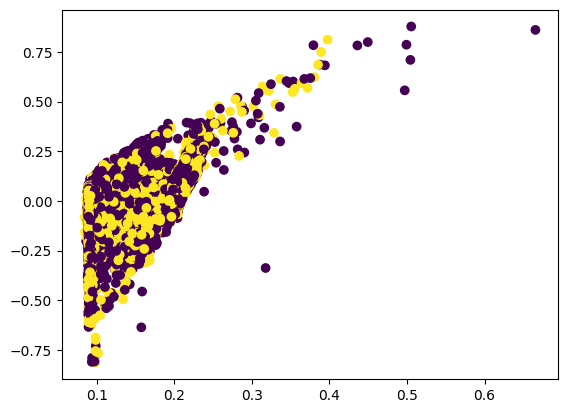

In [ ]:
plt.scatter(roa_data[:, 21], roa_data[:, 36], c=labels.cpu().numpy())

array([0.169385, 0.090364, 0.09009 , ..., 0.091246, 0.176324, 0.091955])

In [ ]:
# labels = []

# for state in final_states:
#     labels.append(system.is_in_attractor(state))
# labels = np.array(labels)


TypeError: 'NoneType' object is not callable

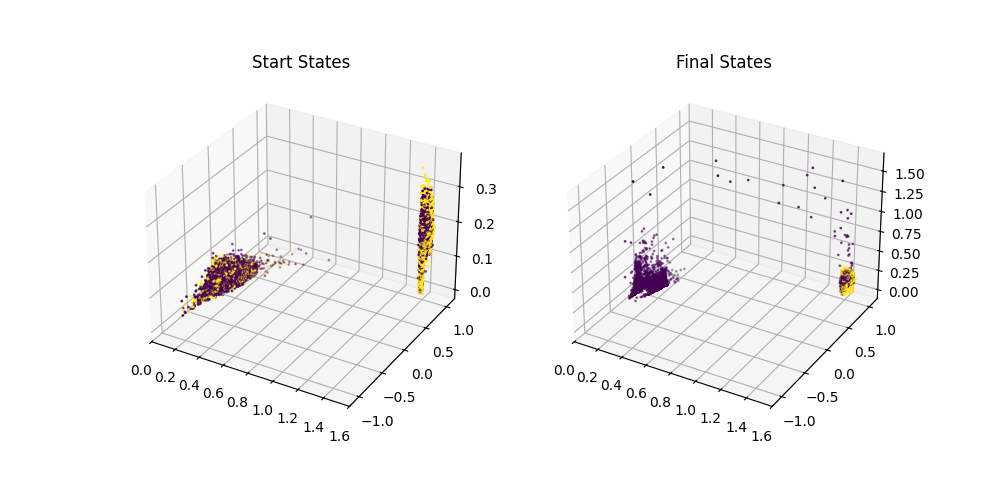

In [88]:


start_states = np.array(start_states)
final_states = np.array(final_states)
fig, ax = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': '3d'})

ax[0].set_xlim(0, 1.6)
ax[0].set_ylim(-1.2, 1.2)
ax[0].set_title("Start States")

ax[1].set_xlim(0, 1.6)
ax[1].set_ylim(-1.2, 1.2)
ax[1].set_title("Final States")

ax[0].scatter(
    start_states[:, 21],
    start_states[:, 36],
    np.sqrt(start_states[:, 37] ** 2 + start_states[:, 38] ** 2),
    c=split_labels,
    s=1
)
ax[1].scatter(
    final_states[:, 21],
    final_states[:, 36],
    np.sqrt(final_states[:, 37] ** 2 + final_states[:, 38] ** 2),
    c=split_labels,
    s=1
)

# Save the figure as a static image (PNG) and as an interactive HTML file
fig.savefig("start_final_3d.png", dpi=300, bbox_inches='tight')

# For interactive saving, use mpld3 or plotly
import mpld3
mpld3.save_html(fig, "start_final_3d_interactive.html")


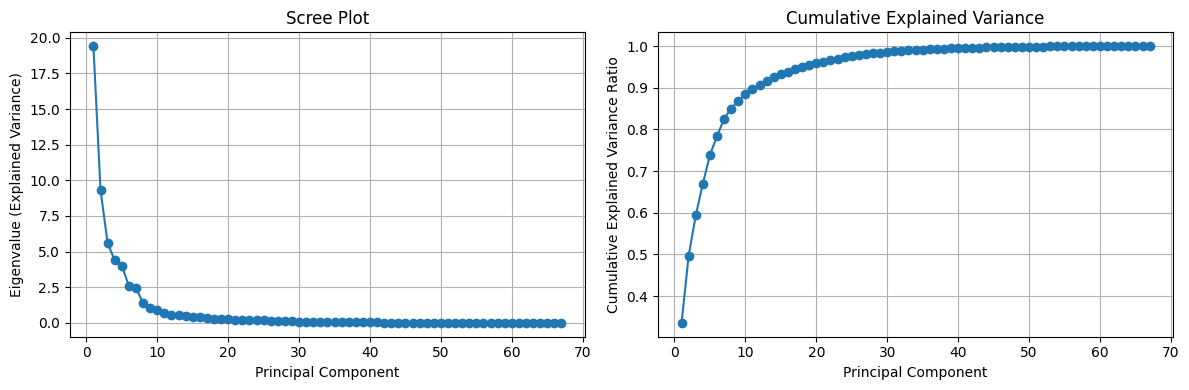

First 10 eigenvectors (principal components):
PC1: [ 1.00222193e-02  6.74949512e-03  3.72358917e-02 -2.08100995e-05
  3.45688064e-02  2.48833291e-02  1.87981814e-02  2.90749398e-02
 -1.93485343e-02 -4.56166109e-03 -2.71766456e-02 -3.12015016e-03
  7.81946678e-02  4.13953701e-02  3.08218378e-02  5.97114365e-02
 -3.71460656e-02  6.24820953e-02  4.62404196e-03 -1.71753464e-02
  5.21533675e-03  1.59916568e-03  7.88464170e-03  2.34968848e-04
  3.40970871e-03  1.05989481e-02  1.35691753e-02 -1.19859331e-02
 -3.03618997e-03  1.53520640e-02 -2.68855547e-03 -8.82565969e-03
  1.58568230e-02 -1.55239401e-02 -1.30132534e-01  7.32851231e-03
  3.31689925e-03 -1.31972344e-03  6.40206168e-04  3.98203582e-03
 -1.13074464e-03  7.44679838e-04  3.56803470e-03  1.03224263e-02
  3.94033654e-02  9.89201146e-03 -1.27466238e-02 -8.66185126e-02
  2.04236622e-02 -1.38879551e-02 -1.74403913e-02  2.05256192e-01
  3.03403808e-01  1.72788854e-01 -2.70723698e-01  1.22393132e-02
  6.05767439e-02  1.97329209e-01  3.939

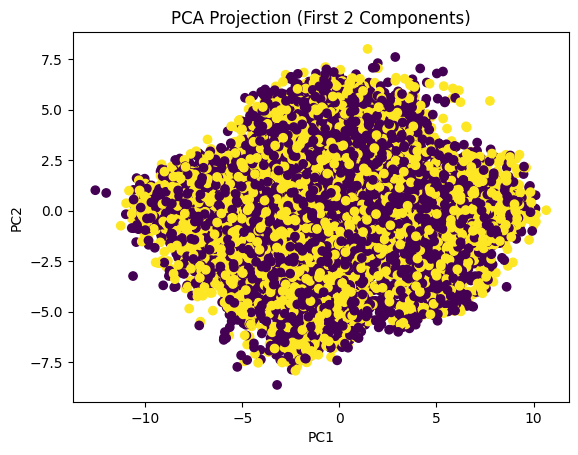

In [10]:
# sklearn pca
from sklearn.decomposition import PCA
pca = PCA(n_components=67)  # keep all components to inspect eigenvalues
pca.fit(roa_data[:, :67])
pca_data = pca.transform(roa_data[:, :67])

# Plot explained variance (eigenvalues)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Scree plot
ax[0].plot(np.arange(1, 68), pca.explained_variance_, 'o-')
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Eigenvalue (Explained Variance)')
ax[0].set_title('Scree Plot')
ax[0].grid(True)

# Cumulative explained variance
ax[1].plot(np.arange(1, 68), np.cumsum(pca.explained_variance_ratio_), 'o-')
ax[1].set_xlabel('Principal Component')
ax[1].set_ylabel('Cumulative Explained Variance Ratio')
ax[1].set_title('Cumulative Explained Variance')
ax[1].grid(True)

plt.tight_layout()
plt.show()

# Print first 10 eigenvectors (principal components)
print("First 10 eigenvectors (principal components):")
for i in range(10):
    print(f"PC{i+1}: {pca.components_[i]}")

# 2-D scatter for the first two PCs
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.scatter(pca_data[:, 0], pca_data[:, 1], c=labels)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('PCA Projection (First 2 Components)')
plt.show()

In [21]:
# sklearn k-means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3000)
kmeans.fit(roa_data[:, :67])


KMeans(n_clusters=3000)

In [19]:
kmeans.cluster_centers_

array([[-0.07780078, -0.20048736,  0.60616662, ...,  0.13336464,
         1.40956678,  0.75      ],
       [-0.68024338, -1.22933939, -0.61877218, ...,  0.87825075,
        -1.15997078,  0.5       ],
       [-0.36958073, -0.3014497 ,  0.61895227, ...,  0.36692403,
         1.72040195,  1.        ],
       ...,
       [-0.61946346, -1.25398391,  0.28815012, ...,  1.52191643,
         3.58551799,  1.        ],
       [ 0.16832232, -0.28175405, -0.054957  , ...,  0.62144619,
         3.30311976,  0.5       ],
       [-0.07724186, -0.60814977,  0.18425448, ...,  0.95020464,
         3.35262773,  1.        ]])

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# Fit k-means with 3000 clusters
kmeans_3000 = KMeans(n_clusters=400, n_init="auto", random_state=0)
cluster_ids = kmeans_3000.fit_predict(roa_data)

# Ensure labels are 0/1 integers
labels = np.asarray(labels).astype(int)
if labels.shape[0] != cluster_ids.shape[0]:
    raise ValueError(f"Length mismatch: labels={labels.shape[0]} vs data/clusters={cluster_ids.shape[0]}")

# Compute counts of labels 0 and 1 within each cluster and the cluster size
ct = pd.crosstab(cluster_ids, labels)
if 0 not in ct.columns:
    ct[0] = 0
if 1 not in ct.columns:
    ct[1] = 0
ct = ct[[0, 1]]
ct.columns = ["count_label_0", "count_label_1"]
ct["cluster_size"] = ct["count_label_0"] + ct["count_label_1"]
ct.index.name = "cluster"
ct["failure_rate"] = ct["count_label_1"] / ct["cluster_size"]
ct["success_rate"] = ct["count_label_0"] / ct["cluster_size"]
cluster_stats = ct.reset_index().sort_values("cluster")


display(cluster_stats)
print(f"Total clusters: {cluster_stats.shape[0]}, total points: {int(cluster_stats['cluster_size'].sum())}")

# save as csv
cluster_stats.to_csv("cluster_stats.csv", index=False)

,cluster,count_label_0,count_label_1,cluster_size,failure_rate,success_rate
0,0,39,40,79,0.506329,0.493671
1,1,12,15,27,0.555556,0.444444
2,2,26,43,69,0.623188,0.376812
3,3,29,28,57,0.491228,0.508772
4,4,14,7,21,0.333333,0.666667
...,...,...,...,...,...,...
395,395,8,4,12,0.333333,0.666667
396,396,19,25,44,0.568182,0.431818
397,397,23,11,34,0.323529,0.676471
398,398,11,20,31,0.645161,0.354839


Total clusters: 400, total points: 15000


In [6]:
import numpy as np
import pandas as pd
from sklearn.cluster import Birch

# Alternative clustering: BIRCH (scales well; auto-determines number of clusters by threshold)
birch = Birch(n_clusters=None, threshold=0.5, branching_factor=50)
birch_labels = birch.fit_predict(roa_data)

# Label-frequency stats per cluster
labels = np.asarray(labels).astype(int)
if labels.shape[0] != birch_labels.shape[0]:
    raise ValueError(f"Length mismatch: labels={labels.shape[0]} vs data/clusters={birch_labels.shape[0]}")

ct = pd.crosstab(birch_labels, labels)
if 0 not in ct.columns:
    ct[0] = 0
if 1 not in ct.columns:
    ct[1] = 0
ct = ct[[0, 1]]
ct.columns = ["count_label_0", "count_label_1"]
ct["cluster_size"] = ct["count_label_0"] + ct["count_label_1"]
ct.index.name = "cluster"
cluster_stats_birch = ct.reset_index().sort_values("cluster")

display(cluster_stats_birch)
print(
    f"BIRCH clusters found: {cluster_stats_birch.shape[0]}, total points: {int(cluster_stats_birch['cluster_size'].sum())}"
)



,cluster,count_label_0,count_label_1,cluster_size
0,0,1,0,1
1,1,1,0,1
2,2,1,0,1
3,3,1,0,1
4,4,0,1,1
...,...,...,...,...
14812,14812,1,0,1
14813,14813,0,1,1
14814,14814,0,1,1
14815,14815,1,0,1


BIRCH clusters found: 14817, total points: 15000


In [7]:
import numpy as np
import pandas as pd

# Density-based clustering: try HDBSCAN, fallback to scikit-learn DBSCAN
try:
    import hdbscan  # pip install hdbscan
    has_hdbscan = True
except Exception:
    has_hdbscan = False

if has_hdbscan:
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=30,
        min_samples=10,
        cluster_selection_epsilon=0.0,
        metric="euclidean",
    )
    density_labels = clusterer.fit_predict(roa_data)
    method_name = "HDBSCAN"
else:
    from sklearn.cluster import DBSCAN

    clusterer = DBSCAN(
        eps=0.5,
        min_samples=10,
        metric="euclidean",
    )
    density_labels = clusterer.fit_predict(roa_data)
    method_name = "DBSCAN"

# labels = np.asarray(split_labels).astype(int)
if labels.shape[0] != density_labels.shape[0]:
    raise ValueError(
        f"Length mismatch: labels={labels.shape[0]} vs data/clusters={density_labels.shape[0]}"
    )

ct = pd.crosstab(density_labels, labels)
if 0 not in ct.columns:
    ct[0] = 0
if 1 not in ct.columns:
    ct[1] = 0
ct = ct[[0, 1]]
ct.columns = ["count_label_0", "count_label_1"]
ct["cluster_size"] = ct["count_label_0"] + ct["count_label_1"]
ct.index.name = "cluster"
cluster_stats_density = ct.reset_index().sort_values("cluster")

# Number of clusters excluding noise (-1)
unique_labels = set(density_labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

display(cluster_stats_density)
print(
    f"{method_name} clusters (excluding noise): {n_clusters}; total points: {int(cluster_stats_density['cluster_size'].sum())}"
)


,cluster,count_label_0,count_label_1,cluster_size
0,-1,8104,6896,15000


DBSCAN clusters (excluding noise): 0; total points: 15000


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans

# Fast k-means variant: MiniBatchKMeans with 3000 clusters
mbk = MiniBatchKMeans(
    n_clusters=3000,
    random_state=0,
    batch_size=4096,
    n_init=10,
    max_no_improvement=20,
    reassignment_ratio=0.0,
)
mbk_labels = mbk.fit_predict(roa_data)

# labels = np.asarray(split_labels).astype(int)
if labels.shape[0] != mbk_labels.shape[0]:
    raise ValueError(
        f"Length mismatch: labels={labels.shape[0]} vs data/clusters={mbk_labels.shape[0]}"
    )

ct = pd.crosstab(mbk_labels, labels)
if 0 not in ct.columns:
    ct[0] = 0
if 1 not in ct.columns:
    ct[1] = 0
ct = ct[[0, 1]]
ct.columns = ["count_label_0", "count_label_1"]
ct["cluster_size"] = ct["count_label_0"] + ct["count_label_1"]
ct.index.name = "cluster"
cluster_stats_mbkmeans = ct.reset_index().sort_values("cluster")

display(cluster_stats_mbkmeans)
print(
    f"MiniBatchKMeans clusters: {cluster_stats_mbkmeans.shape[0]}, total points: {int(cluster_stats_mbkmeans['cluster_size'].sum())}"
)



,cluster,count_label_0,count_label_1,cluster_size
0,0,2,0,2
1,1,2,6,8
2,2,4,0,4
3,3,8,14,22
4,4,5,0,5
...,...,...,...,...
2995,2995,1,1,2
2996,2996,1,0,1
2997,2997,1,1,2
2998,2998,1,1,2


MiniBatchKMeans clusters: 3000, total points: 15000
